In [28]:
# 필요 모듈 호출
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

1. 표본 분포 확인

<AxesSubplot:xlabel='sex', ylabel='count'>

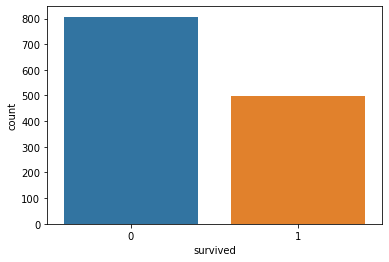

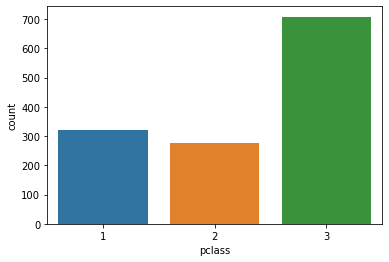

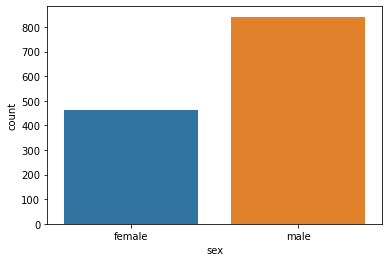

In [29]:
df = pd.read_csv('titanic_processed.csv') #이산 변수는 countplot으로 확인
fig1 = plt.figure()
sns.countplot(x = 'survived', data = df)
fig2 = plt.figure()
sns.countplot(x = 'pclass', data = df)
fig3 = plt.figure()
sns.countplot(x = 'sex', data = df)

<AxesSubplot:xlabel='parch', ylabel='count'>

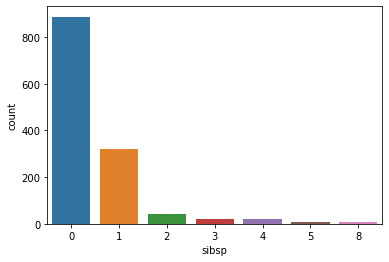

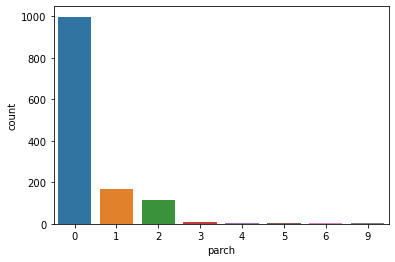

In [30]:
fig1 = plt.figure()
sns.countplot(x = 'sibsp', data = df)
fig2 = plt.figure()
sns.countplot(x = 'parch', data = df)

<AxesSubplot:xlabel='embarked', ylabel='count'>

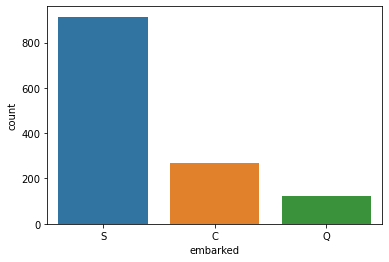

In [31]:
fig1 = plt.figure()
sns.countplot(x = 'embarked', data = df)

<AxesSubplot:ylabel='Density'>

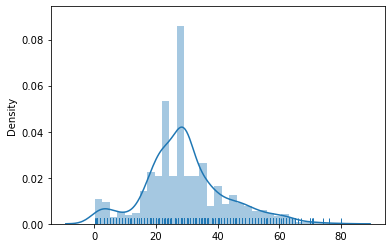

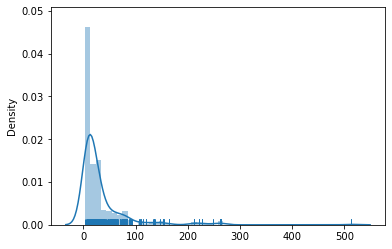

In [32]:
x = df.age.values #연속 변수는 distplot으로 확인
y = df.fare.values
fig1 = plt.figure()
sns.distplot(x, kde = True, rug = True, )
fig2 = plt.figure()
sns.distplot(y, kde = True, rug = True)


1.1 이산 형태의 양적 변수들을 정성 변수로 활용할지에 대한 여부를 판단한다.

<AxesSubplot:xlabel='parch', ylabel='survived'>

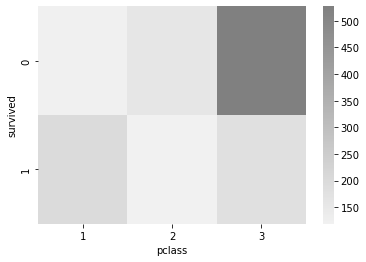

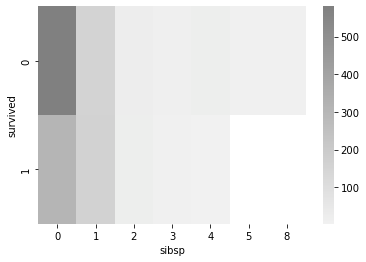

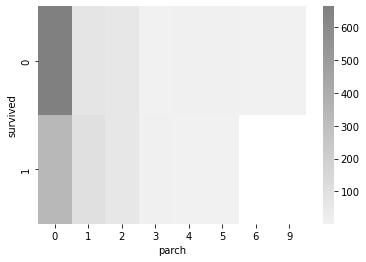

In [33]:
titan_pcl = df.pivot_table(index = 'survived', columns = 'pclass', aggfunc = 'size')
titan_sisp = df.pivot_table(index = 'survived', columns = 'sibsp', aggfunc = 'size')
titan_pach = df.pivot_table(index = 'survived', columns = 'parch', aggfunc = 'size')
fig1 = plt.figure()
sns.heatmap(titan_pcl, cmap = sns.light_palette('gray', as_cmap=True))
fig2 = plt.figure()
sns.heatmap(titan_sisp, cmap = sns.light_palette('gray', as_cmap=True))
fig3 = plt.figure()
sns.heatmap(titan_pach, cmap = sns.light_palette('gray', as_cmap=True))

sibsp와 parch 모두 surivived 0과 1의 값에 대하여 해당 변수의 크기가 커질수록 점차 단조감소 하는 모습을 보이므로 양적 변수로 활용해도 큰 문제가 없어 보인다. 형제자매, 부모와 자녀 등 챙겨야 할 사람이 많을수록 생존률이 떨어진다는 사실 또한 직관적이다.

하지만 pclass의 경우 sruvived 1의 값에 대하여 단조변화 하는 모습을 보이지 않으므로 정성 변수로 처리한다.

<AxesSubplot:xlabel='embarked', ylabel='pclass'>

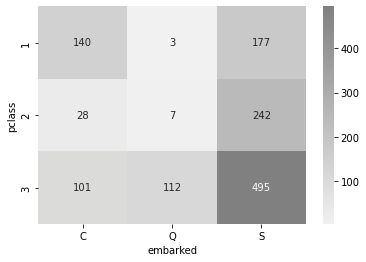

In [34]:
titan_emb = df.pivot_table(index = 'pclass', columns = 'embarked', aggfunc = 'size') #embarked와 pcalss의 상관관계 시각화
fig = plt.figure()
sns.heatmap(titan_emb, cmap = sns.light_palette('gray', as_cmap=True), annot = True, fmt = 'd')

<Figure size 432x288 with 0 Axes>

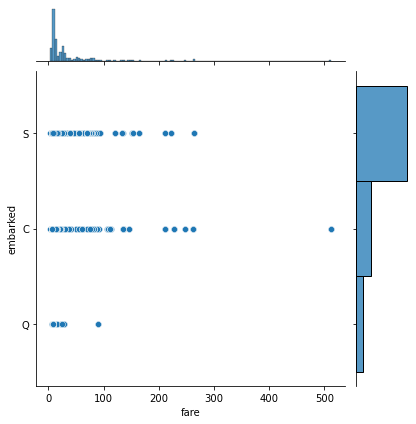

<Figure size 432x288 with 0 Axes>

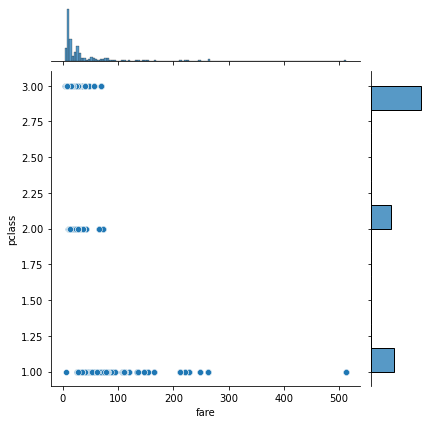

In [35]:
fig1 = plt.figure() #fare와 embarked, pclass의 상관관계
sns.jointplot(x = 'fare', y = 'embarked', data = df)
fig2 = plt.figure()
sns.jointplot(x = 'fare', y = 'pclass', data = df)

탑승한 항구가 어디냐가 생존 여부에 영향을 준다는 사실은 직관적으로 이해되지 않는다. 하지만 어느 지역에서 탑승했느냐가 소득과는 상관관계가 있을 수 있다. 시각화한 자료에 따름녀 C와 S에서 탑승한 사람들의 티켓 요금이 비교적 높으며 상대적으로 높은 클래스의 객실에 묵고 있음을 알 수 있다.

하지만 이는 직접적으로 생존 여부에 direct effect로 작용하기보단 타 설명변수에 partial effect로 작용한다. 이는 설명력을 왜곡 할 수 있으므로 독립변수에서 제하기로 했다.

In [36]:
sex = pd.get_dummies(df['sex'], drop_first = True) #female = 0, male = 1
pcl = pd.get_dummies(df['pclass'])
pcl.columns = ['pcl_1', 'pcl_2', 'pcl_3']
df['sex'] = sex
df['fare'] = np.log(df['fare'])
df['pcl_1'] = pcl['pcl_1']; df['pcl_2'] = pcl['pcl_2']; df['pcl_3'] = pcl['pcl_3']
df = df.drop(['pclass'], axis = 1); df = df.drop(['embarked'], axis = 1)
df

,survived,sex,age,sibsp,parch,fare,pcl_1,pcl_2,pcl_3
0,1,0,29.0000,0,0,5.353456,1,0,0
1,1,1,0.9167,1,2,5.020916,1,0,0
2,0,0,2.0000,1,2,5.020916,1,0,0
3,0,1,30.0000,1,2,5.020916,1,0,0
4,0,0,25.0000,1,2,5.020916,1,0,0
...,...,...,...,...,...,...,...,...,...
1300,0,0,14.5000,1,0,2.670985,0,0,1
1301,0,0,22.0000,1,0,2.670985,0,0,1
1302,0,1,26.5000,0,0,1.977547,0,0,1
1303,0,1,27.0000,0,0,1.977547,0,0,1


티켓 요금이 생존 여부에 영향을 미쳤으리라 추측 가능하지만 표본의 한계로 fare 분포가 지나치게 skewed 되어 있으므로 로그 변환을 취하기로 했다.

<AxesSubplot:ylabel='Density'>

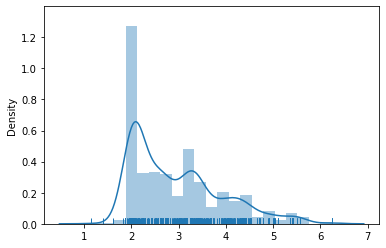

In [37]:
y = df.fare.values #로그 변환 이후의 fare 분포 시각화
fig2 = plt.figure()
sns.distplot(y, kde = True, rug = True)

1.2 다중공선성 확인

In [38]:
def vif_func(data): #VIF 관측 함수 생성
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i)
                 for i in range(df.shape[1])]
    return vif
vif_func(df)

,Features,VIF
0,survived,1.582700
1,sex,1.472201
2,age,1.299929
3,sibsp,1.547214
4,parch,1.455824
5,fare,4.705310
6,pcl_1,27.529391
7,pcl_2,12.950314
8,pcl_3,21.813991


In [39]:
np.corrcoef(df['age'], df['fare'])[0, 1] #age, fare간 상관계수 추정

0.20323058008008776

In [40]:
stats.pearsonr(df['age'], df['fare'])#상관계수의 p-value 측정

(0.2032305800800885, 1.2430719562300721e-13)

VIF를 보면 fare의 VIF값이 꽤 큰 걸 알수있다.(pcl_값들은 상수항이므로 높은 VIF는 무시하기로 했다.) 또한 일반적으로 나이가 높을 수록 소득이 높고 지불한 티켓 비용이 높을 것이라 예상할 수 있다. 따라서 age와 fare간의 상관계수의 그의 p-value를 구해봤다.

상관계수는 0.2로 계산되며 p-value 또한 굉장히 작아 'age와 fare간의 상관관계는 0이다'라는 귀무가설을 기각할 수 밖에 없다. 하지만 나이에 따른 신체능력이 fare와는 무관한게 생존 여부에 영향을 줬을 것이며 omitted variable problem이 우려되므로 age와 fare두 변수를 모두 넣고 추정하기로 했다.

2. 분류모형 설계

In [41]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['survived'], axis=1), df['survived'], test_size=0.3, shuffle=True, )
#train 및 test 데이터를 랜덤하게 분류

In [42]:
x_train #트레이닝 데이터 확인

,sex,age,sibsp,parch,fare,pcl_1,pcl_2,pcl_3
567,0,50.0,0,0,2.351375,0,1,0
614,1,25.0,0,0,1.953028,0,0,1
446,0,54.0,1,3,3.135494,0,1,0
702,1,29.0,1,0,2.671269,0,0,1
586,0,29.0,0,2,3.135494,0,1,0
...,...,...,...,...,...,...,...,...
1010,0,22.0,0,0,2.085672,0,0,1
775,0,30.0,0,0,2.523727,0,0,1
121,0,22.0,0,2,3.901973,1,0,0
536,1,27.0,0,0,2.710268,0,1,0


In [43]:
logreg = LogisticRegression() #discriminant classifier로 logistic regression 사용
logreg.fit(x_train, y_train)
y_pdt = logreg.predict(x_train)
acc_log = round(logreg.score(x_train, y_train)*100, 2)
acc_log

78.75

In [44]:
coef_df = pd.DataFrame(df.columns.delete(0)) #결과 요약
coef_df.columns = ['Features']
coef_df['Correlation'] = pd.Series(logreg.coef_[0])
coef_df.sort_values(by='Correlation', ascending=False)

,Features,Correlation
5,pcl_1,0.839360
4,fare,0.371379
6,pcl_2,0.017648
1,age,-0.046589
3,parch,-0.069609
2,sibsp,-0.516084
7,pcl_3,-0.853265
0,sex,-2.560018


In [45]:
svc = SVC() #discriminant function approach로 support vector machine 사용
svc.fit(x_train, y_train)
y_pdt = svc.predict(x_test)
acc_svc = round(svc.score(x_train, y_train)*100, 2)
acc_svc

65.61

In [46]:
gaus = GaussianNB() #generative classifier로 Gasusian Naive Bayes 사용
gaus.fit(x_train, y_train)
y_pdt = gaus.predict(x_test)
acc_gaus = round(gaus.score(x_train, y_train)*100, 2)
acc_gaus

76.01

In [47]:
dct = DecisionTreeClassifier() #discriminant function approach로 decision tree model 사용
dct.fit(x_train, y_train)
y_pdt = dct.predict(x_test)
acc_dct = round(dct.score(x_train, y_train)*100, 2)
acc_dct

97.48

정확도는 logistic이 78.64%, svc가 64.29%, Gaus가 74.48%, decision tree가 97.26%가 나옴을 볼 수 있다. 하지만 분류모델의 경우 단순히 수치적인 정확도만 중요한 것이 안다. 어떤 종류의 오류를 범했는지도 함께 살펴야 한다.

2.1-2.2 분류 모델 평가

Text(0.5, 1.0, 'Decision Tree Model')

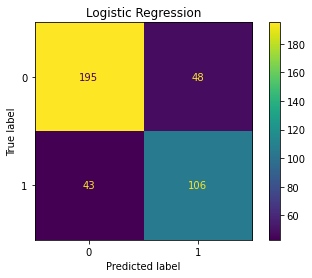

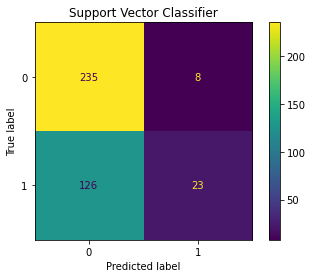

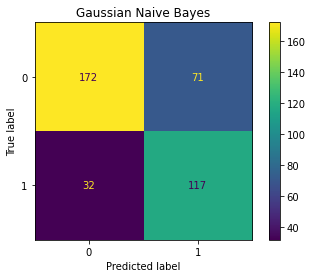

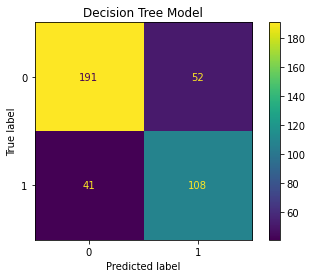

In [48]:
plt1 = plot_confusion_matrix(logreg, x_test, y_test)
plt1.ax_.set_title('Logistic Regression')
plt2 = plot_confusion_matrix(svc, x_test, y_test)
plt2.ax_.set_title('Support Vector Classifier')
plt3 = plot_confusion_matrix(gaus, x_test, y_test)
plt3.ax_.set_title('Gaussian Naive Bayes')
plt4 = plot_confusion_matrix(dct, x_test, y_test)
plt4.ax_.set_title('Decision Tree Model')

가장 안좋은 경우는 1로 predict 했을때 true 값이 0이 나오는 경우, 즉 생존을 예측했는데 사망한 경우이다.(편의상 이를 2종 과오라고 하자.) 이를 감안하고 봤을때 svc는 굉장히 낮은 적중률을 보여주지만 2종 과오는 굉장히 작은 값을 보인다.Gaussian의 경우 적중률은 그리 낮지 않지만 가장 큰 2종 과오 값을 가지므로 이 경우엔 좋은 모델이라 할 수 없다. logistic과 Decision tree 모두 준수한 결과를 냈지만 decision tree모델의 적중률이 미세하게 높고 2종 과오값 또한 작으므로 이 경우 더 좋은 모델이라 할 수 있다.

3. 보험사의 경우에도 마찬가지로 가장 안 좋은 경우는 생존을 예측했지만 사망한 경우(편의상 2종 과오라 하겠다)이다. 이는 보험사에게 예상하지 못한 비용을 발생시킨다. 반면에 사망을 예측했는데 생존한 경우(편의상 1종 과오라 하겠다)는 2종 과오만큼 심각한 상황을 유발하진 않지만 고객에게 더 큰 보험료를 부과해 보험사의 경쟁력을 떨어뜨리는 요인이 된다.

위에서 언급했듯이 이 경우에 가장 좋은 모델은 logistic 모델과 decision tree 모델이다. 해서 이 두 모델을 비교하면, 2종 과오 값은 decision tree 모델이 미세하게 작지만 대신 1종 과오 값이 더 크다. logistic 모델 대신 decision tree 모델을 선택한다면 고객에게 더 큰 보험료를 부과하게 되고 보다 적은 수의 고객만을 보유하게 된다. 2종 과오의 값이 이를 감수할 만큼의 유의미한 차이를 가진다고 보기 어려우므로 여행자보험시장이 경쟁적인 경우, logistic 모델을 사용하는게 더 합리적이라고 추론 가능하다.